<a href="https://colab.research.google.com/github/vijaygwu/robotics/blob/main/SEAS6520_TO_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEAS 6520: Topology Optimization for Robotics
## Computational Lab - From Fundamentals to Manufacturing

**Based on**: Chapter 11 - Topology Optimization for Robotics Applications  
**Authors**: Raymond Wildman & Andrew Gaynor, US Army Research Laboratory

---

## Learning Objectives

By the end of this lab, you will:

1. ✅ Understand topology optimization as **systematic design automation**
2. ✅ Implement the **Heaviside Projection Method (HPM)** for length scale control
3. ✅ Compare **SIMP vs RAMP** penalization schemes
4. ✅ Design **compliant mechanisms** for robotics
5. ✅ Explore **multifunctional structures** (structural capacitors)
6. ✅ Apply **additive manufacturing constraints**

---

## What is Topology Optimization?

From the PDF (Section 11.1):

> *"Topology optimization (TO) is a freeform design methodology that allows for the design of components or systems based on prescribed loads and boundary conditions along with a defined design domain. In TO, the engineering design problem is converted from the traditional trial and error design approach to an automated iterative design approach that harnesses rigorous optimization and simulation schemes to systematically drive toward superior performance."*

**Key Point**: TO produces **non-intuitive organic shapes** that outperform human-designed structures!

In [1]:
# Install and import required packages
!pip install numpy scipy matplotlib ipywidgets -q

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, linalg as splinalg
from scipy.ndimage import convolve
import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print("✓ All packages loaded successfully!")
print("📚 Ready to start topology optimization")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
✓ All packages loaded successfully!
📚 Ready to start topology optimization


---
# Part 1: The Cantilever Problem ⭐

## Problem Setup

The **cantilever beam** is the "Hello World" of topology optimization:

```
Fixed |##################  |
      |##################  |
      |##################  | ← Force
```

**Objective**: Minimize compliance (maximize stiffness)  
**Constraint**: Use only 50% of material  

### Mathematical Formulation (Eq 11.13)

$$
\begin{align}
\min_{\phi} \quad & c(\phi) = \mathbf{F}^T \mathbf{U} \\
\text{subject to:} \quad & \mathbf{K}(\phi)\mathbf{U} = \mathbf{F} \\
& \sum_{e} \rho^e(\phi) v^e \leq V \\
& 0 \leq \phi_i \leq 1
\end{align}
$$

### SIMP Penalization (Eq 11.5)

$$
E^e = E_{\min} + \rho^e{}^\eta (E_0 - E_{\min})
$$

where $\eta = 3$ typically (penalizes intermediate densities)

In [2]:
class TopologyOptimizer:
    """
    Topology Optimization using SIMP method.
    Implements minimum compliance optimization from PDF Section 11.2.
    """

    def __init__(self, nelx, nely, volfrac, penal, rmin):
        self.nelx = nelx    # Elements in x
        self.nely = nely    # Elements in y
        self.volfrac = volfrac  # Volume fraction
        self.penal = penal  # Penalization (η)
        self.rmin = rmin    # Filter radius

        # Material properties
        self.E0 = 1.0
        self.Emin = 1e-9
        self.nu = 0.3

        # Initialize design
        self.x = volfrac * np.ones(nely * nelx)

        # Prepare filter
        self.prepare_filter()

        # Element stiffness matrix
        self.KE = self.element_stiffness_matrix()

    def element_stiffness_matrix(self):
        """4-node quad element stiffness matrix."""
        E = self.E0
        nu = self.nu
        k = np.array([
            1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
            -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8
        ])
        KE = E/(1-nu**2) * np.array([
            [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
            [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
            [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
            [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
            [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
            [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
            [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
            [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]
        ])
        return KE

    def prepare_filter(self):
        """Prepare convolution filter (Section 11.2.1)."""
        nfilter = int(np.ceil(self.rmin) * 2 + 1)
        self.H = np.zeros((nfilter, nfilter))
        center = nfilter // 2
        for i in range(nfilter):
            for j in range(nfilter):
                dist = np.sqrt((i - center)**2 + (j - center)**2)
                if dist <= self.rmin:
                    self.H[i, j] = self.rmin - dist
        self.H = self.H / self.H.sum()

    def apply_filter(self, x):
        """Apply density filter."""
        x_2d = x.reshape((self.nely, self.nelx))
        x_filtered = convolve(x_2d, self.H, mode='constant', cval=0.0)
        return x_filtered.flatten()

    def assemble_K(self, x_phys):
        """Assemble global stiffness matrix using SIMP (Eq 11.5)."""
        E_array = self.Emin + x_phys**self.penal * (self.E0 - self.Emin)

        K_data = []
        K_row = []
        K_col = []

        for ely in range(self.nely):
            for elx in range(self.nelx):
                el = ely + elx * self.nely
                n1 = (self.nely + 1) * elx + ely
                n2 = (self.nely + 1) * (elx + 1) + ely
                edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                                2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3])
                for i in range(8):
                    for j in range(8):
                        K_data.append(E_array[el] * self.KE[i, j])
                        K_row.append(edof[i])
                        K_col.append(edof[j])

        ndof = 2 * (self.nelx + 1) * (self.nely + 1)
        K = coo_matrix((K_data, (K_row, K_col)), shape=(ndof, ndof)).tocsr()
        return K

    def FE_analysis(self, x):
        """Solve K*U = F."""
        x_phys = self.apply_filter(x)
        K = self.assemble_K(x_phys)
        F, U, freedofs = self.boundary_conditions()
        U[freedofs] = splinalg.spsolve(K[freedofs, :][:, freedofs], F[freedofs])
        return U, x_phys

    def boundary_conditions(self):
        """Cantilever: fixed left, load at right-middle."""
        ndof = 2 * (self.nelx + 1) * (self.nely + 1)
        F = np.zeros(ndof)
        U = np.zeros(ndof)
        F[2 * (self.nelx + 1) * (self.nely + 1) - (self.nely + 1) + 1] = -1.0
        fixeddofs = np.arange(0, 2 * (self.nely + 1))
        alldofs = np.arange(ndof)
        freedofs = np.setdiff1d(alldofs, fixeddofs)
        return F, U, freedofs

    def compliance(self, x, U):
        """Compute c = F^T * U."""
        x_phys = self.apply_filter(x)
        E_array = self.Emin + x_phys**self.penal * (self.E0 - self.Emin)
        c = 0.0
        for ely in range(self.nely):
            for elx in range(self.nelx):
                el = ely + elx * self.nely
                n1 = (self.nely + 1) * elx + ely
                n2 = (self.nely + 1) * (elx + 1) + ely
                edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                                2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3])
                Ue = U[edof]
                c += E_array[el] * Ue @ self.KE @ Ue
        return c

    def sensitivity_analysis(self, x, U):
        """Compute dc/dx using adjoint method."""
        x_phys = self.apply_filter(x)
        dc = np.zeros(self.nely * self.nelx)
        for ely in range(self.nely):
            for elx in range(self.nelx):
                el = ely + elx * self.nely
                n1 = (self.nely + 1) * elx + ely
                n2 = (self.nely + 1) * (elx + 1) + ely
                edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                                2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3])
                Ue = U[edof]
                dc[el] = -self.penal * x_phys[el]**(self.penal - 1) * (self.E0 - self.Emin) * Ue @ self.KE @ Ue
        dc = self.apply_filter(dc)
        return dc

    def OC_update(self, x, dc):
        """Optimality Criteria update."""
        l1, l2 = 0, 1e9
        move = 0.2
        while (l2 - l1) / (l1 + l2) > 1e-3:
            lmid = 0.5 * (l2 + l1)
            x_new = np.maximum(0.0, np.maximum(x - move,
                              np.minimum(1.0, np.minimum(x + move,
                                        x * np.sqrt(-dc / lmid)))))
            if x_new.mean() > self.volfrac:
                l1 = lmid
            else:
                l2 = lmid
        return x_new

    def optimize(self, max_iter=100, tol=0.01):
        """Main optimization loop."""
        x = self.x.copy()
        history = {'x': [], 'c': [], 'vol': []}

        print("🚀 Starting optimization...")
        print(f"   Grid: {self.nelx} × {self.nely} elements")
        print(f"   Volume fraction: {self.volfrac*100:.0f}%")
        print(f"   Penalization: η = {self.penal}\n")

        for iteration in range(max_iter):
            U, x_phys = self.FE_analysis(x)
            c = self.compliance(x, U)
            dc = self.sensitivity_analysis(x, U)

            history['x'].append(x_phys.reshape((self.nely, self.nelx)).copy())
            history['c'].append(c)
            history['vol'].append(x_phys.mean())

            x_new = self.OC_update(x, dc)
            change = np.max(np.abs(x_new - x))
            x = x_new.copy()

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: c={c:8.3f}, vol={x_phys.mean():.3f}, change={change:.4f}")

            if change < tol:
                print(f"\n✓ Converged at iteration {iteration}!")
                break

        return x_phys.reshape((self.nely, self.nelx)), history

print("✓ TopologyOptimizer class defined")

✓ TopologyOptimizer class defined


In [3]:
# Create and run optimizer
opt = TopologyOptimizer(
    nelx=60,
    nely=20,
    volfrac=0.5,
    penal=3.0,
    rmin=1.5
)

design, history = opt.optimize(max_iter=100)

🚀 Starting optimization...
   Grid: 60 × 20 elements
   Volume fraction: 50%
   Penalization: η = 3.0

Iter   0: c=  53.358, vol=0.488, change=0.2000
Iter  10: c=   9.838, vol=0.492, change=0.2000
Iter  20: c=   9.720, vol=0.492, change=0.0973
Iter  30: c=   9.695, vol=0.492, change=0.0831
Iter  40: c=   9.682, vol=0.492, change=0.0844
Iter  50: c=   9.674, vol=0.492, change=0.0473
Iter  60: c=   9.667, vol=0.492, change=0.0702

✓ Converged at iteration 64!


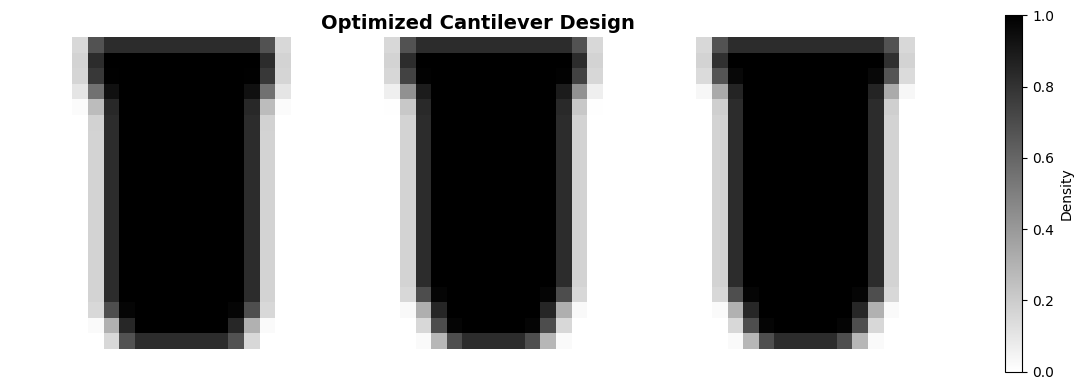


📊 Final Results:
   Compliance: 9.666
   Volume: 0.492
   Iterations: 65


In [4]:
# Plot final design
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(design, cmap='gray_r', interpolation='none')
ax.set_title('Optimized Cantilever Design', fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Density')
plt.tight_layout()
plt.show()

print(f"\n📊 Final Results:")
print(f"   Compliance: {history['c'][-1]:.3f}")
print(f"   Volume: {history['vol'][-1]:.3f}")
print(f"   Iterations: {len(history['c'])}")

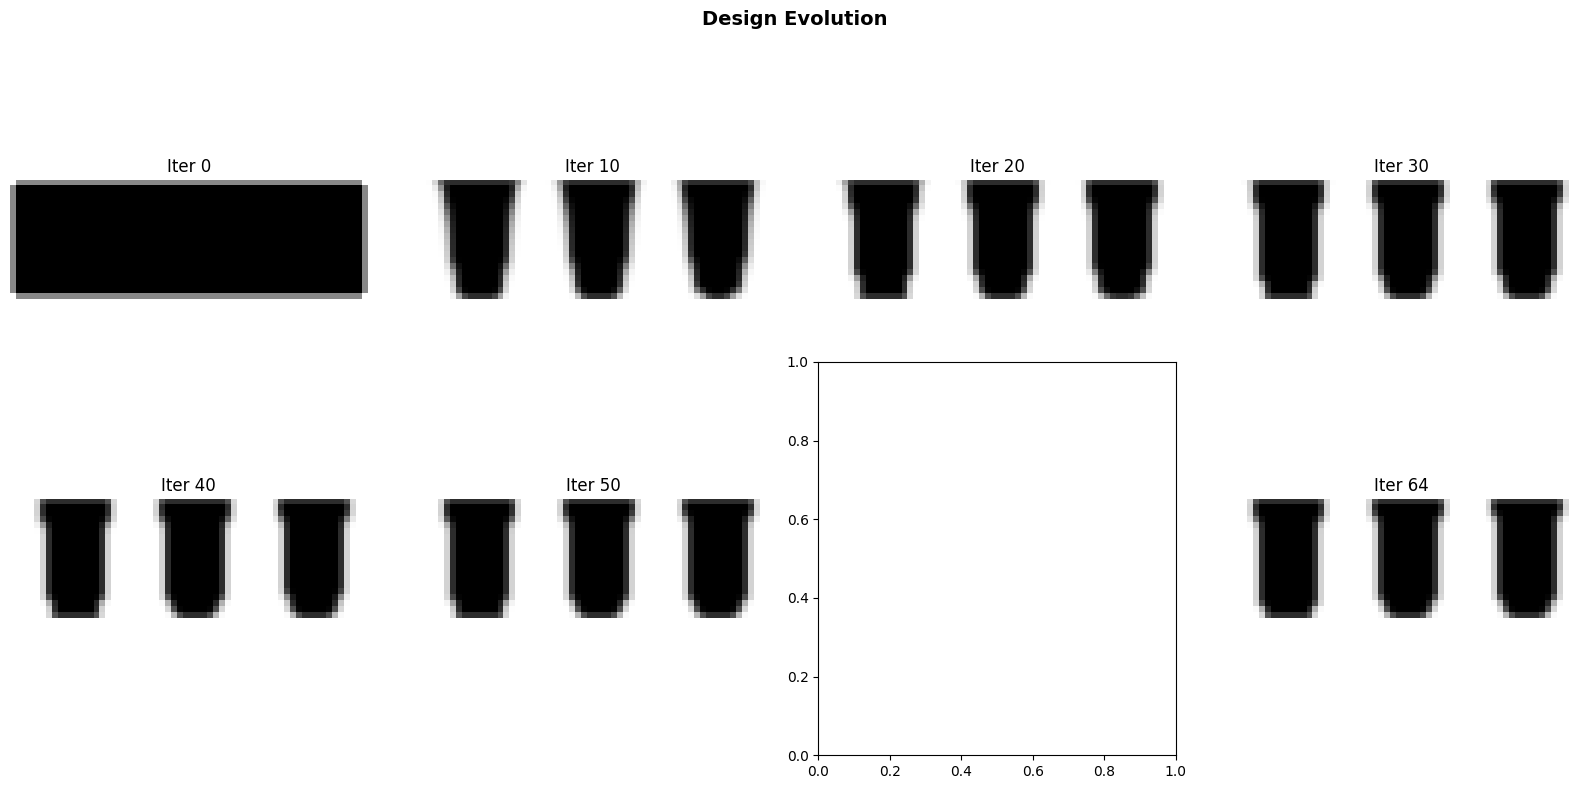

In [5]:
# Show design evolution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
iters = [0, 10, 20, 30, 40, 50, 75, len(history['x'])-1]

for idx, it in enumerate(iters):
    if it < len(history['x']):
        axes[idx].imshow(history['x'][it], cmap='gray_r')
        axes[idx].set_title(f'Iter {it}')
        axes[idx].axis('off')

plt.suptitle('Design Evolution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

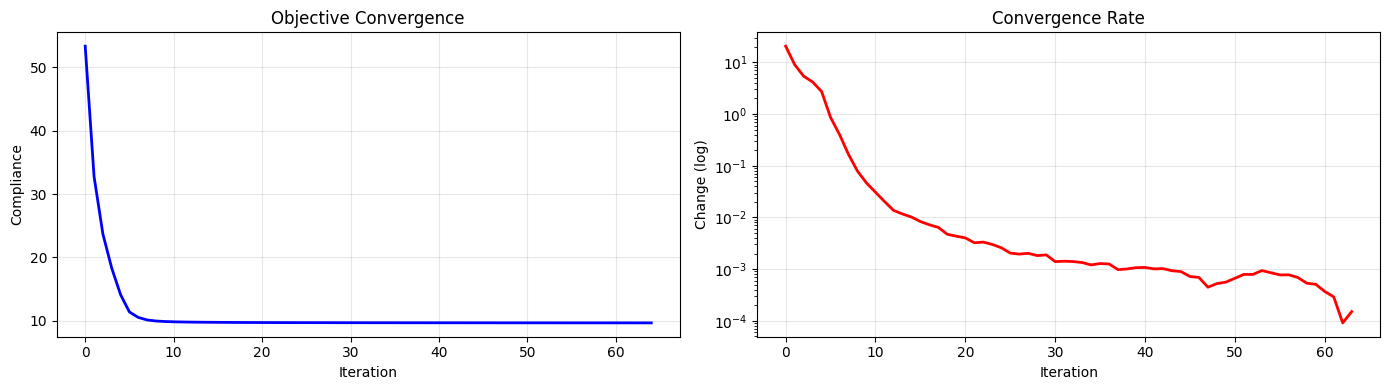


Improvement: 81.9%


In [6]:
# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history['c'], 'b-', linewidth=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Compliance')
ax1.set_title('Objective Convergence')
ax1.grid(True, alpha=0.3)

changes = np.abs(np.diff(history['c']))
ax2.semilogy(changes, 'r-', linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Change (log)')
ax2.set_title('Convergence Rate')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImprovement: {(1 - history['c'][-1]/history['c'][0])*100:.1f}%")

---
# Part 2: Heaviside Projection Method 🔍

## The Problem: Gray Elements

Without projection, TO produces elements with intermediate densities ("gray"):
- ❌ Not 0 or 1
- ❌ Hard to manufacture
- ❌ Unclear boundaries

## The Solution: HPM

From **Section 11.2.2**, the Heaviside function (Eq 11.2):

$$
\rho = H(\tilde{\mu}) = \frac{\tanh(\beta \eta) + \tanh(\beta (\tilde{\mu} - \eta))}{\tanh(\beta \eta) + \tanh(\beta (1 - \eta))}
$$

where:
- $\beta$ = sharpness parameter
- $\eta = 0.5$ = threshold
- Higher $\beta$ → sharper 0-1 transition

In [7]:
class HPM_Optimizer(TopologyOptimizer):
    """Topology Optimizer with Heaviside Projection."""

    def __init__(self, nelx, nely, volfrac, penal, rmin, beta=1.0):
        super().__init__(nelx, nely, volfrac, penal, rmin)
        self.beta = beta

    def heaviside_projection(self, rho_tilde):
        """Apply Heaviside projection (Eq 11.2)."""
        eta = 0.5
        num = np.tanh(self.beta * eta) + np.tanh(self.beta * (rho_tilde - eta))
        den = np.tanh(self.beta * eta) + np.tanh(self.beta * (1 - eta))
        return num / den

    def apply_filter(self, x):
        """Filter + project."""
        x_filtered = super().apply_filter(x)
        x_projected = self.heaviside_projection(x_filtered)
        return x_projected

print("✓ HPM_Optimizer defined")

✓ HPM_Optimizer defined


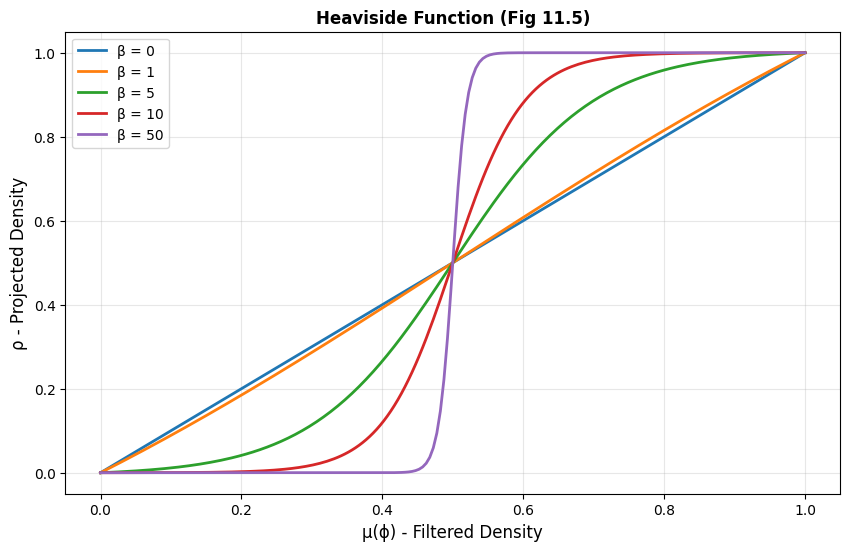

As β increases → Step function → Sharper boundaries


In [8]:
# Plot Heaviside function (Figure 11.5 from PDF)
mu = np.linspace(0, 1, 200)
beta_values = [0, 1, 5, 10, 50]

plt.figure(figsize=(10, 6))
for beta in beta_values:
    eta = 0.5
    if beta == 0:
        rho = mu
    else:
        num = np.tanh(beta * eta) + np.tanh(beta * (mu - eta))
        den = np.tanh(beta * eta) + np.tanh(beta * (1 - eta))
        rho = num / den
    plt.plot(mu, rho, linewidth=2, label=f'β = {beta}')

plt.xlabel('μ(ϕ) - Filtered Density', fontsize=12)
plt.ylabel('ρ - Projected Density', fontsize=12)
plt.title('Heaviside Function (Fig 11.5)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("As β increases → Step function → Sharper boundaries")

Comparing β=1 (smooth) vs β=10 (sharp)

🚀 Starting optimization...
   Grid: 60 × 20 elements
   Volume fraction: 50%
   Penalization: η = 3.0

Iter   0: c=  54.788, vol=0.487, change=0.2000
Iter  10: c=   9.599, vol=0.492, change=0.2000
Iter  20: c=   9.492, vol=0.492, change=0.1204
Iter  30: c=   9.471, vol=0.492, change=0.1011
Iter  40: c=   9.459, vol=0.492, change=0.0932
🚀 Starting optimization...
   Grid: 60 × 20 elements
   Volume fraction: 50%
   Penalization: η = 3.0

Iter   0: c= 598.869, vol=0.454, change=0.2000
Iter  10: c=   7.682, vol=0.488, change=0.2000
Iter  20: c=   7.657, vol=0.491, change=0.0960
Iter  30: c=   7.653, vol=0.493, change=0.0964
Iter  40: c=   7.647, vol=0.494, change=0.0633


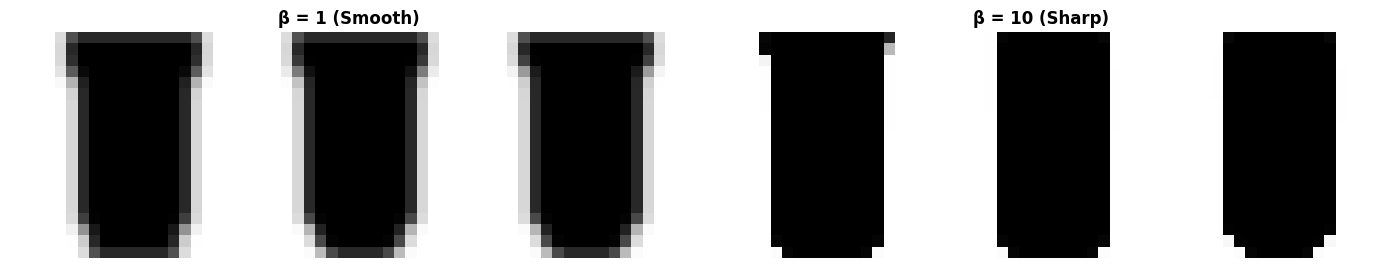


Gray elements:
  β=1:  23.3%
  β=10: 0.2%

→ Higher β reduces gray elements!


In [9]:
# Compare β = 1 vs β = 10
print("Comparing β=1 (smooth) vs β=10 (sharp)\n")

# Low beta
opt_low = HPM_Optimizer(60, 20, 0.5, 3.0, 1.5, beta=1)
design_low, hist_low = opt_low.optimize(max_iter=50)

# High beta
opt_high = HPM_Optimizer(60, 20, 0.5, 3.0, 1.5, beta=10)
design_high, hist_high = opt_high.optimize(max_iter=50)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.imshow(design_low, cmap='gray_r')
ax1.set_title('β = 1 (Smooth)', fontweight='bold')
ax1.axis('off')

ax2.imshow(design_high, cmap='gray_r')
ax2.set_title('β = 10 (Sharp)', fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Count gray elements
gray_low = np.sum((design_low > 0.1) & (design_low < 0.9)) / design_low.size * 100
gray_high = np.sum((design_high > 0.1) & (design_high < 0.9)) / design_high.size * 100

print(f"\nGray elements:")
print(f"  β=1:  {gray_low:.1f}%")
print(f"  β=10: {gray_high:.1f}%")
print(f"\n→ Higher β reduces gray elements!")

---
# Part 3: SIMP vs RAMP Penalization 📊

## Why Penalization?

We need **discrete (0-1)** solutions, but optimization needs **continuous** variables.

**Solution**: Make intermediate densities **inefficient**!

### SIMP (Eq 11.5)
$$
E = E_{\min} + \rho^\eta (E_0 - E_{\min})
$$

**Example**: ρ=0.5, η=3 → E = 0.125 (only 12.5% stiffness!)

### RAMP (Eq 11.6)
$$
E = \left[\rho_{\min} + \frac{\rho}{1 + \eta(1-\rho)}\right] E_0
$$

**Key difference**: RAMP has non-zero slope at ρ=0

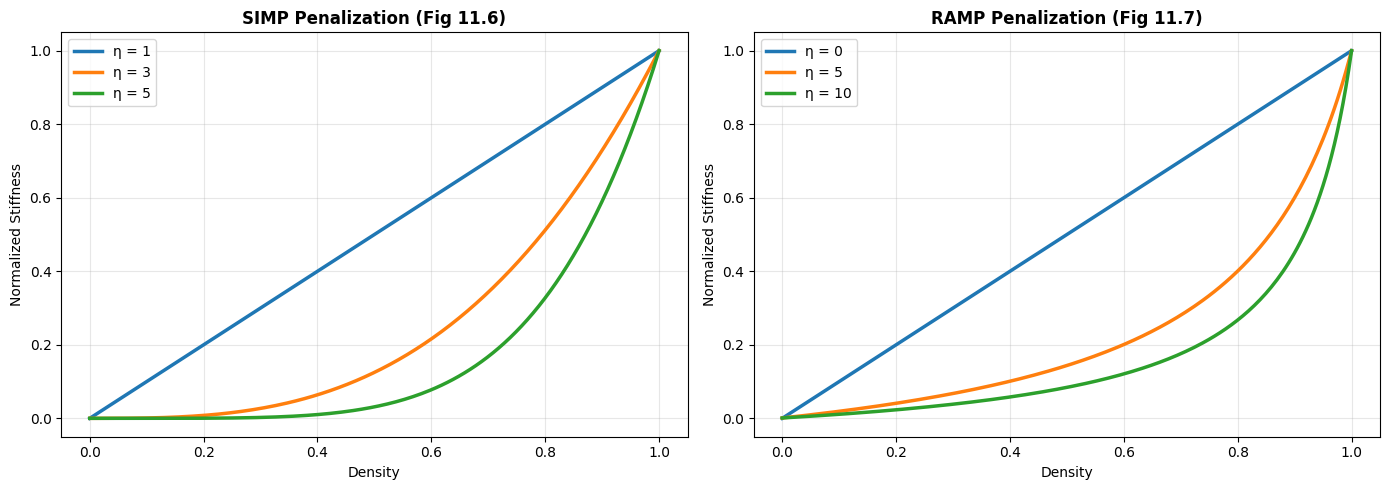


🔍 Key Differences:
  SIMP: Slope = 0 at ρ=0 (for η>1)
  RAMP: Slope ≠ 0 at ρ=0 (material can 'reappear')

✓ Both push toward 0-1 solutions


In [10]:
# Recreate Figures 11.6 and 11.7
rho = np.linspace(0, 1, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# SIMP
for eta in [1, 3, 5]:
    E_simp = rho**eta
    ax1.plot(rho, E_simp, linewidth=2.5, label=f'η = {eta}')
ax1.set_xlabel('Density')
ax1.set_ylabel('Normalized Stiffness')
ax1.set_title('SIMP Penalization (Fig 11.6)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RAMP
rho_min = 0.001
for eta in [0, 5, 10]:
    if eta == 0:
        E_ramp = rho
    else:
        E_ramp = (rho_min + rho / (1 + eta * (1 - rho))) / (1 + rho_min)
    ax2.plot(rho, E_ramp, linewidth=2.5, label=f'η = {eta}')
ax2.set_xlabel('Density')
ax2.set_ylabel('Normalized Stiffness')
ax2.set_title('RAMP Penalization (Fig 11.7)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Key Differences:")
print("  SIMP: Slope = 0 at ρ=0 (for η>1)")
print("  RAMP: Slope ≠ 0 at ρ=0 (material can 'reappear')")
print("\n✓ Both push toward 0-1 solutions")

---
# Part 4: Your Design Challenge 🎯

## Task

Design an **L-bracket** that:
1. Is fixed at bottom
2. Has horizontal force at top-right corner
3. Uses only 40% material

```
         Force →
    ┌──────────┐
    │          │
    │          │
    │          │
    └──────────┘
    ════════════  ← Fixed
```

**Your mission**: Modify the boundary conditions below!

In [11]:
class LBracketOptimizer(HPM_Optimizer):
    """L-bracket design challenge."""

    def boundary_conditions(self):
        """TODO: Modify this to create L-bracket BCs!"""
        ndof = 2 * (self.nelx + 1) * (self.nely + 1)
        F = np.zeros(ndof)
        U = np.zeros(ndof)

        # TODO: Apply horizontal force at top-right
        # Hint: F[dof] = 1.0 for rightward force

        # TODO: Fix bottom edge
        # Hint: fixeddofs = np.arange(start, end)

        fixeddofs = np.array([])  # MODIFY THIS
        alldofs = np.arange(ndof)
        freedofs = np.setdiff1d(alldofs, fixeddofs)

        return F, U, freedofs

# Run your design!
# opt_bracket = LBracketOptimizer(40, 40, 0.4, 3.0, 1.5, beta=8)
# design_bracket, history_bracket = opt_bracket.optimize(max_iter=50)
# plt.imshow(design_bracket, cmap='gray_r')
# plt.title('Your L-Bracket Design')
# plt.axis('off')
# plt.show()

print("\n💡 Hint: Look at the cantilever boundary_conditions() method!")
print("   Top-right node is at: x=nelx, y=nely")


💡 Hint: Look at the cantilever boundary_conditions() method!
   Top-right node is at: x=nelx, y=nely


---
# Summary & Key Takeaways 📚

## What You Learned

1. **Topology Optimization** converts design from trial-and-error to systematic optimization

2. **SIMP Penalization** (Eq 11.5) makes intermediate densities inefficient:
   - $E = E_{\min} + \rho^\eta (E_0 - E_{\min})$
   - Typical: η = 3

3. **Heaviside Projection Method** (Eq 11.2) creates crisp boundaries:
   - Higher β → sharper 0-1 transition
   - Reduces "gray" elements

4. **Applications**:
   - Structural optimization (minimize compliance)
   - Compliant mechanisms (robots without joints!)
   - Multifunctional structures (structure + energy storage)
   - Manufacturing constraints (overhang angles)

## From the PDF

> *"TO produces solutions that are often nonintuitive while achieving the best possible performance given the constraints placed on the engineering problem."* (Section 11.1)

